In [ ]:
import numpy as np
from scipy.io import loadmat
import os
import h5py
import pickle
import matplotlib.pyplot as plt

import pyroomacoustics as pra
from pyroomacoustics import directivities as dr
from pyroomacoustics.experimental.rt60 import measure_rt60
import argparse

In [ ]:
word = "hello"
os.path.join('home/ci411/',f'{word} world')

In [8]:
from room_scaper import  tau_loading, sofa_utils
import room_sim

In [9]:
tau_db_dir = "/scratch/ci411/SRIR_DATASETS/TAU_SRIR_DB/TAU-SRIR_DB"
mat_files = os.listdir(tau_db_dir)
room_name = 'sc203'
mat_file = [filename for filename in mat_files if room_name in filename][0]

In [10]:
mat_file

'rirs_06_sc203.mat'

Estimated rt60: 3.3968000000000003


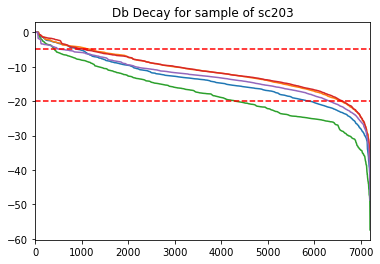

In [12]:
#estimate RT60 of a given room via schroeder's method
#note that decay_db should be 60, but most RIRs are truncated
#before this drop, so we use a shorter method (assuming the
#db falloff is roughly linear)

rir_file = '/scratch/ci411/SRIR_DATASETS/TAU_SRIR_DB/TAU-SRIR_DB/rirs_06_sc203.mat'
#custom function for sampling TAU-SRIR database for RIRs
rir_samples = tau_loading.load_rir_sample(rir_file, t_type='linear')
decay_db = 15
sr = 24000

#visualize our rt60 estimations
fig = plt.figure()
plt.title("Db Decay for sample of sc203")
ax = plt.gca()

rt_estimates = []
for i in range(rir_samples.shape[0]):
    rt_estimates.append(measure_rt60(rir_samples[i], fs=sr, decay_db=decay_db))
    room_sim.plot_energy_db(ax, rir_samples[i,:])

plt.hlines([-5, -5-decay_db], 0, 7200, linestyle='--', color='r')
plt.xlim(0,7200)

rt_estimates = np.array(rt_estimates) * (60/decay_db)
rt_avg = np.average(rt_estimates)
print(f"Estimated rt60: {rt_avg}")

In [22]:
#determine absorption coefficients, necessary max order of reflections
#given estimated room dimensions, estimated rt60
#define room

room_dim = [11,8,4]
e_absorption, max_order = pra.inverse_sabine(rt_avg, room_dim)
print(max_order)
#set for efficiency
max_order = 10

room_sc203 = pra.ShoeBox(
    room_dim, fs=sr, materials=pra.Material(e_absorption), max_order=max_order
)

325


In [23]:
#define mic geometry
mic_coords, mic_dirs = room_sim.get_tetra_mics()

In [24]:
#grab paths from tau_srir
tau_db_dir = '/scratch/ci411/SRIR_DATASETS/TAU_SRIR_DB/TAU-SRIR_DB'
room_idx = 5

paths, paths_meta, room_meta = tau_loading.load_paths(room_idx, tau_db_dir)

In [25]:
#center mic coordinates based on array center location
mic_loc_center = np.array([0.05, 0.05, 0.05])
mic_locs = room_sim.center_mic_coords(mic_coords, mic_loc_center)

In [26]:
room_center = np.array([room_dim[0]/2, room_dim[1]/2, 0])
#choose path based on traj/height:
t_idx = 0
h_idx = 4
path = paths[t_idx][h_idx]
mic_center = room_meta['microphone_position'] + room_center
centered_path = path + mic_center
centered_mics = mic_locs + mic_center

In [27]:
room_sc203.add_microphone_array(centered_mics.T, directivity=mic_dirs)
for source in centered_path[::10]:
    room_sc203.add_source(source)

(0.0, 4.4)

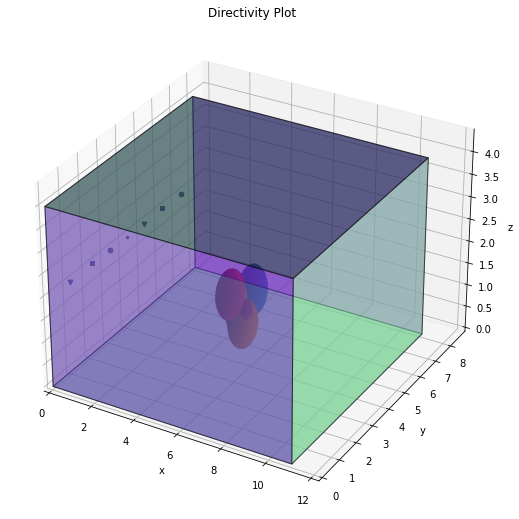

In [28]:
ax = plt.figure(figsize=(9,9)).add_subplot(projection='3d')
room_sc203.plot(ax=ax)
ax.set_xlim(0,room_dim[0]*1.1)
ax.set_ylim(0,room_dim[1]*1.1)
ax.set_zlim(0,room_dim[2]*1.1)

In [29]:
room_sc203.compute_rir()

File is valid: True
